In [1]:
# Importing key libraries 
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse,mse
from statsmodels.tsa.api import SARIMAX

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load auto_arima function
from pmdarima import auto_arima # for determining ARIMA orders

In [4]:
# Import Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [31]:
# Load dataset
df = pd.read_excel('NumberOfPensionBenefeciaries.xlsx',index_col='Rok', parse_dates=True)

In [32]:
df.head()

,Pocet_Poberatelov_Dochodkov,Pocet_Poberatelov_Starobnych_Dochodkov,Pocet_Obyvatelov,Podiel,Ln-NumberOfOldAgePensionBeneficiaries,EXP
Rok,,,,,,
1999-01-01,1193749,771323,5393382,0.143013,13.555863,771323.0
2000-01-01,1197363,778030,5398657,0.144115,13.564520,778030.0
2001-01-01,1190550,772341,5378783,0.143590,13.557181,772341.0
2002-01-01,1199281,783676,5378951,0.145693,13.571751,783676.0
2003-01-01,1204763,796251,5374873,0.148143,13.587670,796251.0


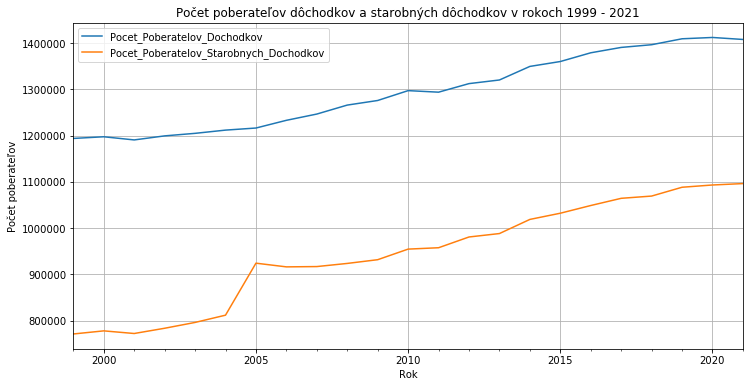

In [34]:
#Data Plot
title = 'Počet poberateľov dôchodkov a starobných dôchodkov v rokoch 1999 - 2021'
xlabel = 'Rok'
ylabel = 'Počet poberateľov'

ax = df[['Pocet_Poberatelov_Dochodkov','Pocet_Poberatelov_Starobnych_Dochodkov']].plot(figsize=(12,6),title=title, grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

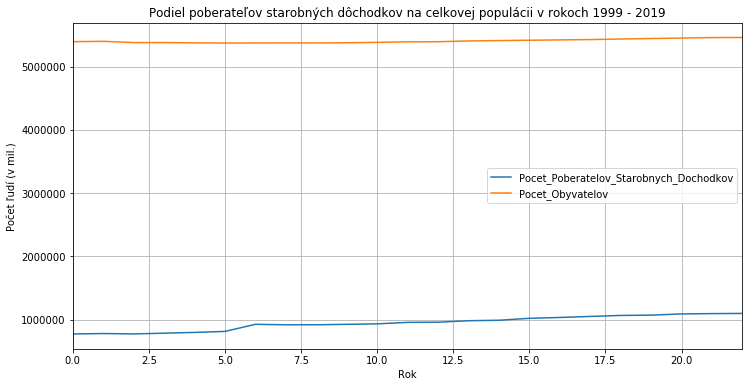

In [25]:
# Another plot
title = 'Podiel poberateľov starobných dôchodkov na celkovej populácii v rokoch 1999 - 2019'
xlabel = 'Rok'
ylabel = 'Počet ľudí (v mil.)'

ax = df[['Pocet_Poberatelov_Starobnych_Dochodkov','Pocet_Obyvatelov']].plot(figsize=(12,6),title=title, grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

In [41]:
# Load dataset
df2 = pd.read_excel('NumberOfPensionBenefeciaries.xlsx',index_col='Rok')

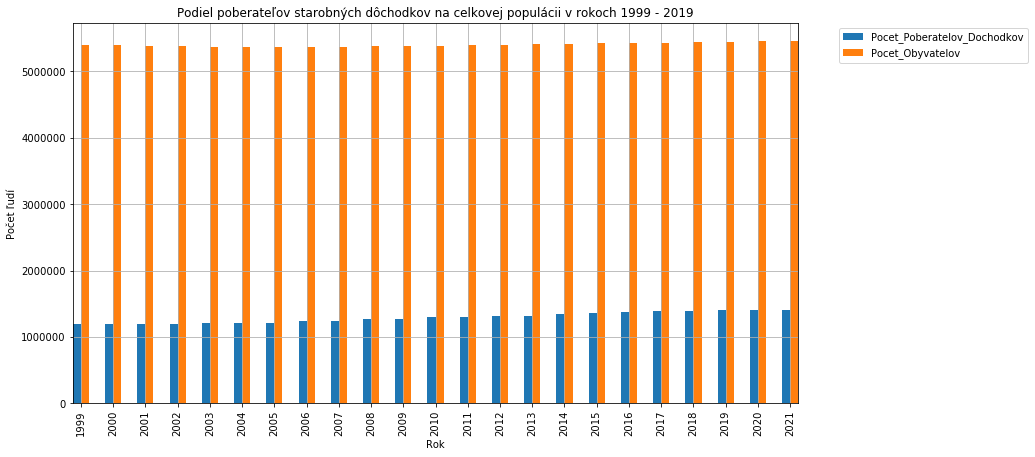

In [60]:
# Another plot
title = 'Podiel poberateľov starobných dôchodkov na celkovej populácii v rokoch 1999 - 2019'
xlabel = 'Rok'
ylabel = 'Počet ľudí'

ax = df2[['Pocet_Poberatelov_Dochodkov','Pocet_Obyvatelov']].plot.bar(figsize=(13,7),title=title, grid=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

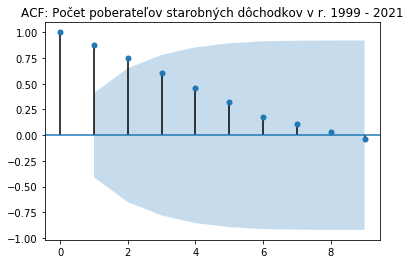

In [12]:
#ACF plot
title = 'ACF: Počet poberateľov starobných dôchodkov v r. 1999 - 2021'
lags = 9
plot_acf(df['NumberOfOldAgePensionBeneficiaries'],title=title,lags=lags);

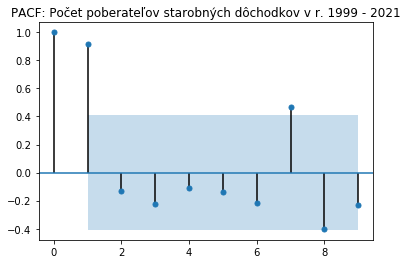

In [13]:
#PACF plot
title = 'PACF: Počet poberateľov starobných dôchodkov v r. 1999 - 2021'
lags = 9
plot_pacf(df['NumberOfOldAgePensionBeneficiaries'],title=title,lags=lags);

In [14]:
adf_test(df['NumberOfOldAgePensionBeneficiaries'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.729114
p-value                  0.069134
# lags used              8.000000
# observations          14.000000
critical value (1%)     -4.012034
critical value (5%)     -3.104184
critical value (10%)    -2.690987
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


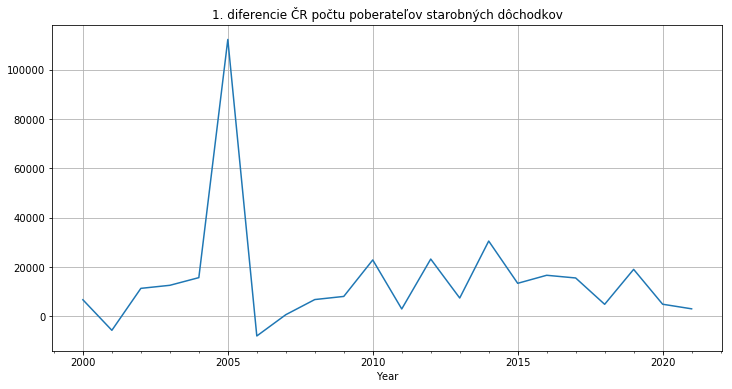

In [15]:
#Differencing data due to non stationarity - 1st difference
df['diff-1'] = diff(df['NumberOfOldAgePensionBeneficiaries'],k_diff=1)
title = '1. diferencie ČR počtu poberateľov starobných dôchodkov'
df['diff-1'].plot(grid=True, title=title, figsize=(12,6));

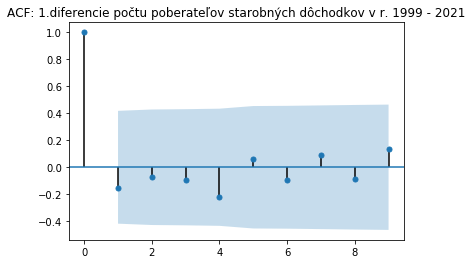

In [16]:
#ACF plot for 1st difference
title='ACF: 1.diferencie počtu poberateľov starobných dôchodkov v r. 1999 - 2021'
lags=10
plot_acf(df['diff-1'].dropna(),title=title,lags=np.arange(lags));

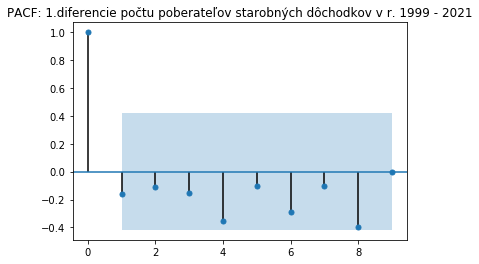

In [17]:
#PACF plot for 1st difference
title='PACF: 1.diferencie počtu poberateľov starobných dôchodkov v r. 1999 - 2021'
lags=10
plot_pacf(df['diff-1'].dropna(),title=title,lags=np.arange(lags));

In [18]:
adf_test(df['diff-1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.268110
p-value                  0.996424
# lags used              8.000000
# observations          13.000000
critical value (1%)     -4.068854
critical value (5%)     -3.127149
critical value (10%)    -2.701730
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


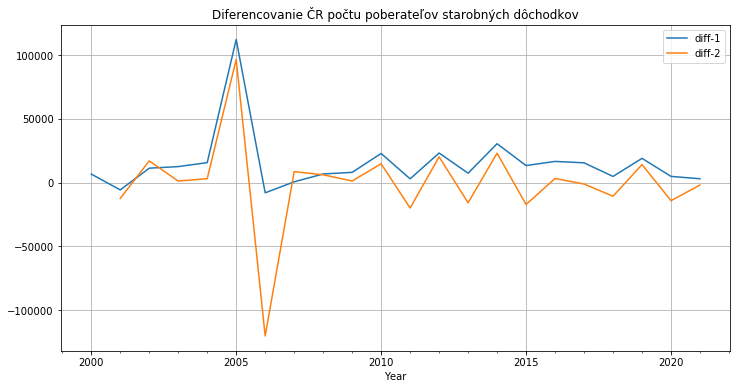

In [19]:
#Differencing data due to non stationarity - 2nd difference
df['diff-2'] = diff(df['NumberOfOldAgePensionBeneficiaries'],k_diff=2)
title = 'Diferencovanie ČR počtu poberateľov starobných dôchodkov'
df[['diff-1','diff-2']].plot(grid=True, title=title, figsize=(12,6));

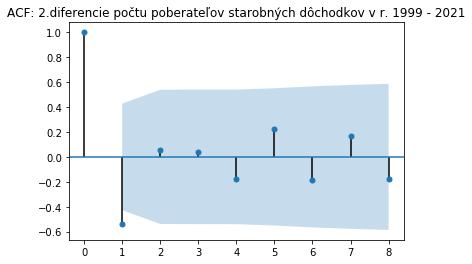

In [21]:
#ACF plot for 2nd difference
title='ACF: 2.diferencie počtu poberateľov starobných dôchodkov v r. 1999 - 2021'
lags=9
plot_acf(df['diff-2'].dropna(),title=title,lags=np.arange(lags));  

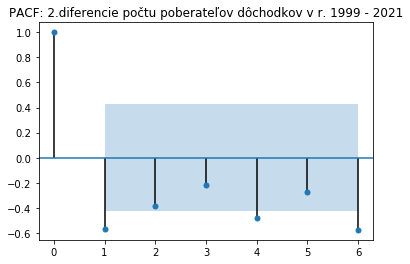

In [23]:
#PACF plot for 2nd difference
title='PACF: 2.diferencie počtu poberateľov dôchodkov v r. 1999 - 2021'
lags=7
plot_pacf(df['diff-2'].dropna(),title=title,lags=np.arange(lags));

In [25]:
adf_test(df['diff-2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.000000
p-value                  0.958532
# lags used              9.000000
# observations          11.000000
critical value (1%)     -4.223238
critical value (5%)     -3.189369
critical value (10%)    -2.729839
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [26]:
# Load dataset
df = pd.read_excel('NumberOfPensionBenefeciaries.xlsx',index_col='Year',parse_dates=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 1999-01-01 to 2021-01-01
Data columns (total 6 columns):
NumberOfPensionBeneficiaries             23 non-null int64
NumberOfOldAgePensionBeneficiaries       23 non-null int64
Population                               23 non-null int64
Share                                    23 non-null float64
Ln-NumberOfOldAgePensionBeneficiaries    23 non-null float64
EXP                                      23 non-null float64
dtypes: float64(3), int64(3)
memory usage: 1.3 KB


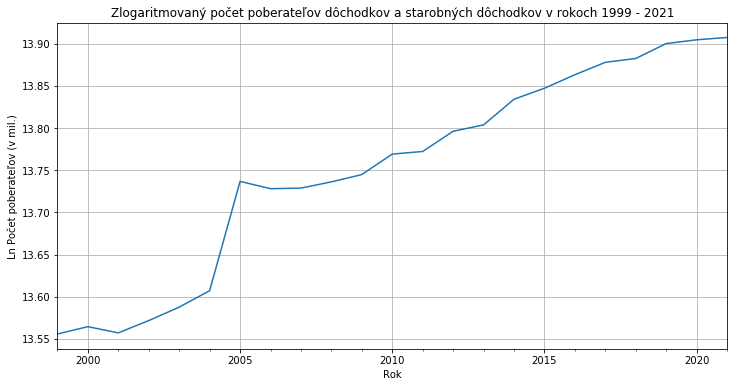

In [28]:
#Data Plot
title = 'Zlogaritmovaný počet poberateľov dôchodkov a starobných dôchodkov v rokoch 1999 - 2021'
xlabel = 'Rok'
ylabel = 'Ln Počet poberateľov (v mil.)'

ax = df['Ln-NumberOfOldAgePensionBeneficiaries'].plot(figsize=(12,6),title=title, grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

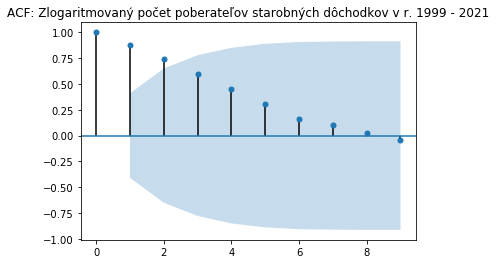

In [29]:
#ACF plot
title = 'ACF: Zlogaritmovaný počet poberateľov starobných dôchodkov v r. 1999 - 2021'
lags = 9
plot_acf(df['Ln-NumberOfOldAgePensionBeneficiaries'],title=title,lags=lags);

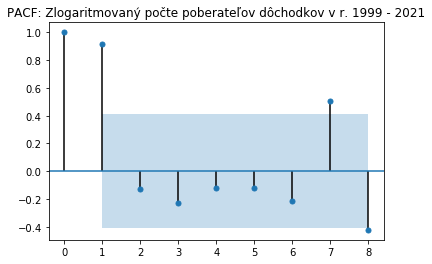

In [30]:
#PACF plot for 2nd difference
title='PACF: Zlogaritmovaný počte poberateľov dôchodkov v r. 1999 - 2021'
lags=9
plot_pacf(df['Ln-NumberOfOldAgePensionBeneficiaries'].dropna(),title=title,lags=np.arange(lags));

In [31]:
adf_test(df['Ln-NumberOfOldAgePensionBeneficiaries'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.214219
p-value                  0.019176
# lags used              8.000000
# observations          14.000000
critical value (1%)     -4.012034
critical value (5%)     -3.104184
critical value (10%)    -2.690987
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [32]:
#Running auto_arima function which measures many different models, do the differencing on its own

stepwise_fit = auto_arima(df['Ln-NumberOfOldAgePensionBeneficiaries'], start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-92.195, BIC=-87.831, Fit time=0.090 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-93.217, BIC=-91.035, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-91.575, BIC=-88.302, Fit time=0.028 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-91.664, BIC=-88.391, Fit time=0.028 seconds
Total fit time: 0.157 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   22
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  48.608
Method:                           css   S.D. of innovations              0.027
Date:                Sun, 06 Mar 2022   AIC                            -93.217
Time:                        18:52:56   BIC                            -91.035
Sample:                             1   HQIC                           -92.703
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0160      0.006      2.822      0.010       0.005       0.027
==============================================================================
"""

In [33]:
#Running auto_arima function which measures many different models, do the differencing on its own

stepwise_fit = auto_arima(df['NumberOfOldAgePensionBeneficiaries'], start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=508.398, BIC=512.762, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 0); AIC=508.613, BIC=510.795, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=510.090, BIC=513.363, Fit time=0.068 seconds
Fit ARIMA: order=(0, 1, 1); AIC=509.911, BIC=513.185, Fit time=0.018 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=510.246, BIC=515.701, Fit time=0.149 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.355 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -250.199
Method:                       css-mle   S.D. of innovations          20060.142
Date:                Sun, 06 Mar 2022   AIC                            508.398
Time:                        18:53:02   BIC                            512.762
Sample:                             1   HQIC                           509.426
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.591e+04   1167.871     13.626      0.000    1.36e+04    1.82e+04
ar.L1.D.y      0.5174      0.204      2.538      0.020       0.118       0.917
ma.L1.D.y     -1.0000      0.133     -7.535      0.000      -1.260      -0.740
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9327           +0.0000j            1.9327            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
# Splitting into train and test period
train = df.iloc[:17]
test = df.iloc[17:]

In [35]:
#Checking the best model after splitting

model = ARIMA(train['NumberOfOldAgePensionBeneficiaries'],order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ARIMA Model Results                                       
================================================================================================
Dep. Variable:     D.NumberOfOldAgePensionBeneficiaries   No. Observations:                   16
Model:                                   ARIMA(0, 1, 0)   Log Likelihood                -185.772
Method:                                             css   S.D. of innovations          26683.214
Date:                                  Sun, 06 Mar 2022   AIC                            375.543
Time:                                          18:53:20   BIC                            377.088
Sample:                                      01-01-2000   HQIC                           375.622
                                           - 01-01-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.63e+04   6670.803      2.444      0.027    3230.091    2.94e+04
==============================================================================
"""

In [102]:
model = ARIMA(train['Ln-NumberOfOldAgePensionBeneficiaries'],order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        ARIMA Model Results                                        
===================================================================================================
Dep. Variable:     D.Ln-NumberOfOldAgePensionBeneficiaries   No. Observations:                   16
Model:                                      ARIMA(0, 1, 0)   Log Likelihood                  33.077
Method:                                                css   S.D. of innovations              0.031
Date:                                     Sun, 20 Feb 2022   AIC                            -62.154
Time:                                             19:28:13   BIC                            -60.609
Sample:                                         01-01-2000   HQIC                           -62.075
                                              - 01-01-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.008      2.379      0.017       0.003       0.033
==============================================================================
"""

In [125]:
model2 = ARIMA(train['Ln-NumberOfOldAgePensionBeneficiaries'],order=(0,1,1))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        ARIMA Model Results                                        
===================================================================================================
Dep. Variable:     D.Ln-NumberOfOldAgePensionBeneficiaries   No. Observations:                   16
Model:                                      ARIMA(0, 1, 1)   Log Likelihood                  33.308
Method:                                            css-mle   S.D. of innovations              0.030
Date:                                     Sun, 20 Feb 2022   AIC                            -60.616
Time:                                             20:35:24   BIC                            -58.298
Sample:                                         01-01-2000   HQIC                           -60.497
                                              - 01-01-2015                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.0184      0.006      3.017      0.003       0.006       0.030
ma.L1.D.Ln-NumberOfOldAgePensionBeneficiaries    -0.2040      0.321     -0.636      0.524      -0.832       0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            4.9011           +0.0000j            4.9011            0.0000
-----------------------------------------------------------------------------
"""

In [103]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,0) Test predictions')

In [126]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions2 = results2.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,1) Test predictions')

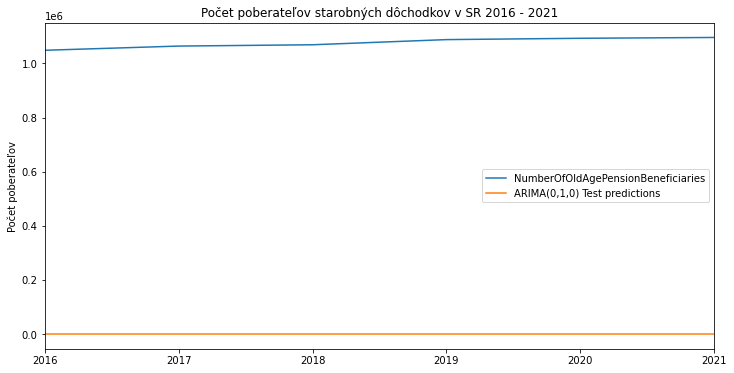

In [104]:
#Plotting predictions vs. expected data
title = 'Počet poberateľov starobných dôchodkov v SR 2016 - 2021'
ylabel='Počet poberateľov'
xlabel='' # we don't really need a label here

ax = test['NumberOfOldAgePensionBeneficiaries'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

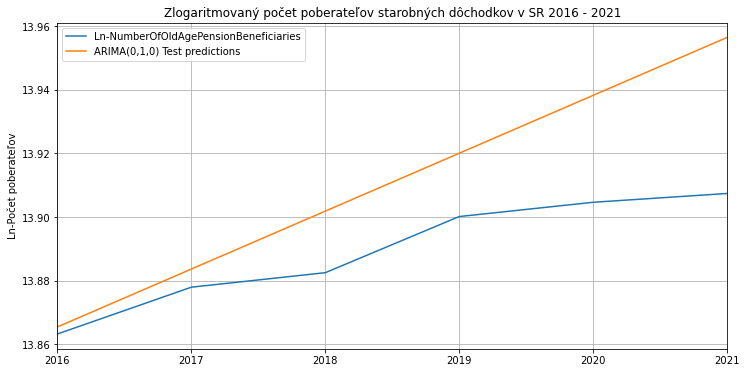

In [124]:
#Plotting predictions vs. expected data
title = 'Zlogaritmovaný počet poberateľov starobných dôchodkov v SR 2016 - 2021'
ylabel='Ln-Počet poberateľov'
xlabel='' # we don't really need a label here

ax = test['Ln-NumberOfOldAgePensionBeneficiaries'].plot(legend=True,grid=True, figsize=(12,6),title=title)
predictions.plot(legend=True,grid=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

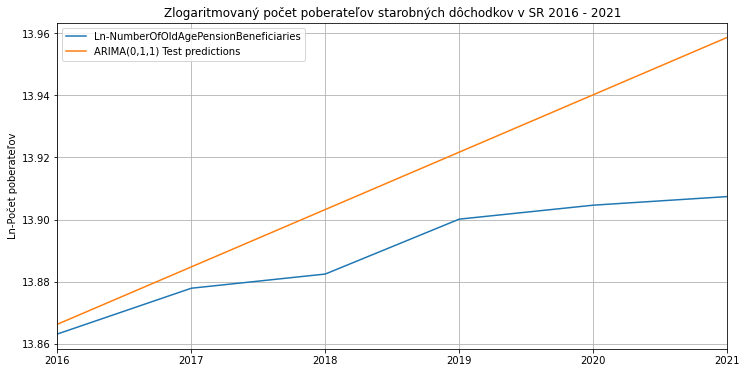

In [127]:
#Plotting predictions vs. expected data
title = 'Zlogaritmovaný počet poberateľov starobných dôchodkov v SR 2016 - 2021'
ylabel='Ln-Počet poberateľov'
xlabel='' # we don't really need a label here

ax = test['Ln-NumberOfOldAgePensionBeneficiaries'].plot(legend=True,grid=True, figsize=(12,6),title=title)
predictions2.plot(legend=True,grid=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [107]:
# predicted vs. expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Ln-NumberOfOldAgePensionBeneficiaries'][i]}")

predicted=13.8654087 , expected=13.863197256396408
predicted=13.8836173 , expected=13.877915241589037
predicted=13.9018259 , expected=13.88247270225311
predicted=13.92003449, expected=13.900127403684152
predicted=13.93824309, expected=13.904615159297087
predicted=13.95645169, expected=13.907383017391387


In [108]:
#MSE and RMSE calculation
error = mse(test['Ln-NumberOfOldAgePensionBeneficiaries'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')
error = rmse(test['Ln-NumberOfOldAgePensionBeneficiaries'], predictions)
print(f'ARIMA(0,1,0) RMSE Error: {error:11.10}')

ARIMA(0,1,0) MSE Error: 0.0007244691828
ARIMA(0,1,0) RMSE Error: 0.0269159652


In [109]:
#Retraining the model on full dataset
model = ARIMA(df['Ln-NumberOfOldAgePensionBeneficiaries'],order=(0,1,0))
results = model.fit()
forecast = results.predict(len(df),len(df)+8,typ='levels').rename('ARIMA(0,1,0) Forecast')

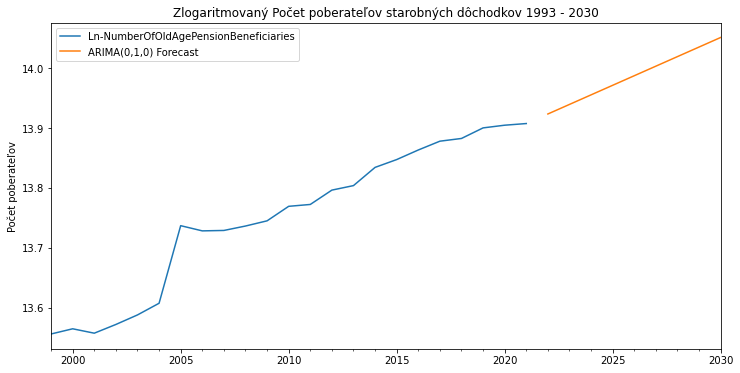

In [110]:
# Plot predictions against known values
title = 'Zlogaritmovaný Počet poberateľov starobných dôchodkov 1993 - 2030'
ylabel='Počet poberateľov'
xlabel='' # we don't really need a label here

ax = df['Ln-NumberOfOldAgePensionBeneficiaries'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [111]:
forecast

2022-01-01    13.923361
2023-01-01    13.939339
2024-01-01    13.955318
2025-01-01    13.971296
2026-01-01    13.987274
2027-01-01    14.003252
2028-01-01    14.019230
2029-01-01    14.035209
2030-01-01    14.051187
Freq: AS-JAN, Name: ARIMA(0,1,0) Forecast, dtype: float64

In [118]:
# Load dataset
df2 = pd.read_excel('ForecastedNumberOfPensionBenefeciaries.xlsx',index_col='Year',parse_dates=True)

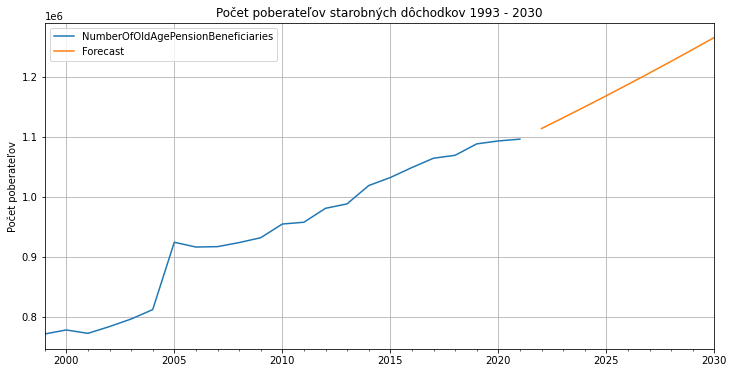

In [121]:
# Plot predictions against known values
title = 'Počet poberateľov starobných dôchodkov 1993 - 2030'
ylabel='Počet poberateľov'
xlabel='' # we don't really need a label here

ax = df2['NumberOfOldAgePensionBeneficiaries'].plot(legend=True,grid=True, figsize=(12,6),title=title)
df2['Forecast'].plot(legend=True, grid=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [129]:
df

,NumberOfPensionBeneficiaries,NumberOfOldAgePensionBeneficiaries,Population,Share,Ln-NumberOfOldAgePensionBeneficiaries,Forecast
Year,,,,,,
1999-01-01,1193749.0,771323.0,5393382.0,0.143013,13.555863,NaN
2000-01-01,1197363.0,778030.0,5398657.0,0.144115,13.564520,NaN
2001-01-01,1190550.0,772341.0,5378783.0,0.143590,13.557181,NaN
2002-01-01,1199281.0,783676.0,5378951.0,0.145693,13.571751,NaN
2003-01-01,1204763.0,796251.0,5374873.0,0.148143,13.587670,NaN
2004-01-01,1211745.0,811937.0,5371875.0,0.151146,13.607178,NaN
2005-01-01,1216253.0,924285.0,5372685.0,0.172034,13.736776,NaN
2006-01-01,1232904.0,916296.0,5372928.0,0.170539,13.728095,NaN
2007-01-01,1246438.0,916941.0,5373180.0,0.170651,13.728798,NaN
